In [20]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_squared_error,
    r2_score,
    mean_absolute_error,
)
#using a fixed random seed to have reproducable result
np.random.seed(42)

DATA_PATH = Path("../data_manual/merged_fitness_workouts_daily.csv")
FIG_DIR = Path("../figures")   
FIG_DIR.mkdir(exist_ok=True)

#loading the daily level datas
df = pd.read_csv(DATA_PATH)
df["date"] = pd.to_datetime(df["date"]).dt.date

In [21]:

df = df.sort_values("date")

if "day_of_week" not in df.columns:
    df["day_of_week"] = pd.to_datetime(df["date"]).dt.weekday

if "is_weekend" not in df.columns:
    df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)

for col in ["workout_done", "total_like_save", "fitness_total", "total_workout_minutes"]:
    if col in df.columns and f"{col}_lag1" not in df.columns:
        df[f"{col}_lag1"] = df[col].shift(1)

if "workout_minutes_roll7" not in df.columns:
    df["workout_minutes_roll7"] = df["total_workout_minutes"].rolling(7, min_periods=1).mean()

if "fitness_total_roll7" not in df.columns:
    df["fitness_total_roll7"] = df["fitness_total"].rolling(7, min_periods=1).mean()

if "total_like_save_roll7" not in df.columns:
    df["total_like_save_roll7"] = df["total_like_save"].rolling(7, min_periods=1).mean()

df = df.dropna().reset_index(drop=True)

print(df.columns)
print("Num of rows:", len(df))

Index(['date', 'total_like', 'fitness_like', 'total_save', 'fitness_save',
       'fitness_total', 'total_like_save', 'fitness_share_likesaves',
       'total_workout_minutes', 'active_energy_total', 'resting_energy_total',
       'avg_heart_rate', 'max_heart_rate', 'intensity_avg', 'step_count_total',
       'workout_done', 'day_of_week', 'is_weekend', 'workout_done_lag1',
       'total_like_save_lag1', 'fitness_total_lag1',
       'total_workout_minutes_lag1', 'workout_minutes_roll7',
       'fitness_total_roll7', 'total_like_save_roll7'],
      dtype='object')
Num of rows: 369


In [22]:

#aspects i checked to see if i did workout or not on a given day
cls_features = [
    "total_like_save",
    "fitness_total",
    "total_like_save_roll7",
    "fitness_total_roll7",
    "day_of_week",
    "is_weekend",
    "workout_done_lag1",
    "total_like_save_lag1",
    "fitness_total_lag1",
]

X_cls = df[cls_features].values
y_cls = df["workout_done"].astype(int).values

#part for the trail-test split
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls,
    y_cls,
    test_size=0.2,
    random_state=42,
    stratify=y_cls,
)



#standartization part for the logistic reg
scaler_cls = StandardScaler()
X_train_cls_sc = scaler_cls.fit_transform(X_train_cls)
X_test_cls_sc = scaler_cls.transform(X_test_cls)

#simple linear classifier part, one of the parts i have been recommended by chatgpt for possible usefullness
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_cls_sc, y_train_cls)
y_pred_log = log_reg.predict(X_test_cls_sc)
y_proba_log = log_reg.predict_proba(X_test_cls_sc)[:, 1]
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)
rf_clf.fit(X_train_cls, y_train_cls)
y_pred_rf = rf_clf.predict(X_test_cls)
y_proba_rf = rf_clf.predict_proba(X_test_cls)[:, 1]

#useful info print parts that i have used to make comments about, again got help from chatgpt about which areas would be usefull
print(classification_report(y_test_cls, y_pred_log))
print("Accuracy:", accuracy_score(y_test_cls, y_pred_log))
print("Precision:", precision_score(y_test_cls, y_pred_log))
print("Recall:", recall_score(y_test_cls, y_pred_log))
print("F1:", f1_score(y_test_cls, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test_cls, y_proba_log))
print("Confusion matrix:\n", confusion_matrix(y_test_cls, y_pred_log))
print(classification_report(y_test_cls, y_pred_rf))
print("Accuracy:", accuracy_score(y_test_cls, y_pred_rf))
print("Precision:", precision_score(y_test_cls, y_pred_rf))
print("Recall:", recall_score(y_test_cls, y_pred_rf))
print("F1:", f1_score(y_test_cls, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test_cls, y_proba_rf))
print("Confusion matrix:\n", confusion_matrix(y_test_cls, y_pred_rf))

              precision    recall  f1-score   support

           0       0.61      0.91      0.73        46
           1       0.20      0.04      0.06        28

    accuracy                           0.58        74
   macro avg       0.40      0.47      0.40        74
weighted avg       0.45      0.58      0.48        74

Accuracy: 0.581081081081081
Precision: 0.2
Recall: 0.03571428571428571
F1: 0.06060606060606061
ROC-AUC: 0.41537267080745344
Confusion matrix:
 [[42  4]
 [27  1]]
              precision    recall  f1-score   support

           0       0.64      0.91      0.75        46
           1       0.50      0.14      0.22        28

    accuracy                           0.62        74
   macro avg       0.57      0.53      0.49        74
weighted avg       0.58      0.62      0.55        74

Accuracy: 0.6216216216216216
Precision: 0.5
Recall: 0.14285714285714285
F1: 0.2222222222222222
ROC-AUC: 0.5458074534161491
Confusion matrix:
 [[42  4]
 [24  4]]


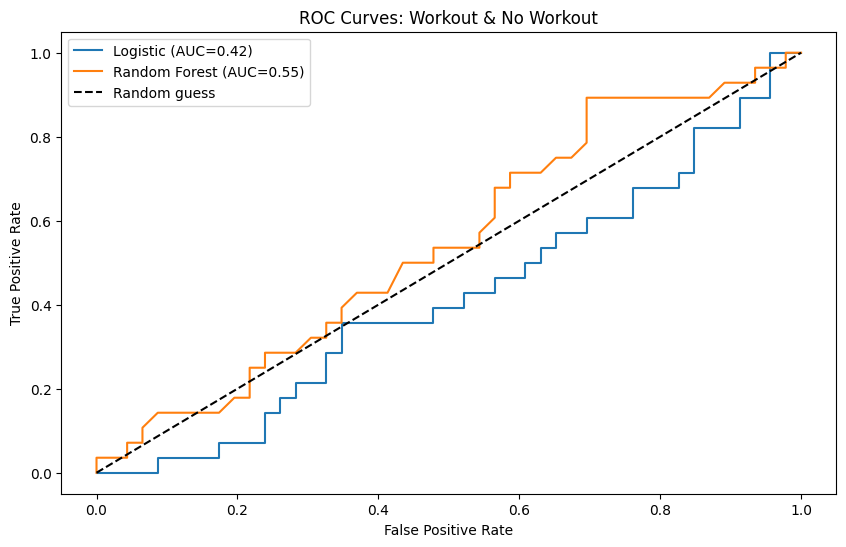

In [23]:

#part where i compute the roc curve and auc 
fpr_log, tpr_log, _ = roc_curve(y_test_cls, y_proba_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test_cls, y_proba_rf)
auc_log = roc_auc_score(y_test_cls, y_proba_log)
auc_rf = roc_auc_score(y_test_cls, y_proba_rf)

plt.figure(figsize=(10, 6))
plt.plot(fpr_log, tpr_log, label=f"Logistic (AUC={auc_log:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={auc_rf:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: Workout & No Workout")
plt.legend()

#saving and prinitng the results
roc_path = FIG_DIR / "classification_results.png"
plt.savefig(roc_path, dpi=200, bbox_inches="tight")
plt.show()

In [24]:
#using only days with workout for the regression
df_reg = df[df["workout_done"] == 1].copy()


#aspects i check for the predicted total workout duration
reg_features = [
    "total_like_save",
    "fitness_total",
    "total_like_save_roll7",
    "fitness_total_roll7",
    "day_of_week",
    "is_weekend",
    "total_like_save_lag1",
    "fitness_total_lag1",
    "total_workout_minutes_lag1",
]

X_reg = df_reg[reg_features].values
y_reg = df_reg["total_workout_minutes"].values

#train test split part
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg,
    y_reg,
    test_size=0.2,
    random_state=42,
)

#again the standardization part for the linear ridge this time
scaler_reg = StandardScaler()
X_train_reg_sc = scaler_reg.fit_transform(X_train_reg)
X_test_reg_sc = scaler_reg.transform(X_test_reg)


#ridge regression  part
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_reg_sc, y_train_reg)
y_pred_ridge = ridge.predict(X_test_reg_sc)


#this is the part where i compute the values for standart reg.
r2_ridge = r2_score(y_test_reg, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test_reg, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test_reg, y_pred_ridge))

print("R^2:", r2_ridge)
print("MAE:", mae_ridge)
print("RMSE:", rmse_ridge)


#also tried to use random forest reg as i have seen it previously in ML class i took in exchange
rf_reg = RandomForestRegressor(n_estimators=500, random_state=42)
rf_reg.fit(X_train_reg, y_train_reg)
y_pred_rf_reg = rf_reg.predict(X_test_reg)

#compute values for the random forest
r2_rf = r2_score(y_test_reg, y_pred_rf_reg)
mae_rf = mean_absolute_error(y_test_reg, y_pred_rf_reg)
rmse_rf = np.sqrt(mean_squared_error(y_test_reg, y_pred_rf_reg))

print("R^2:", r2_rf)
print("MAE:", mae_rf)
print("RMSE:", rmse_rf)

R^2: -0.02670078268667675
MAE: 27.80147739646888
RMSE: 36.65927957388317
R^2: -0.054159427748239564
MAE: 28.419151190476175
RMSE: 37.146262893191775


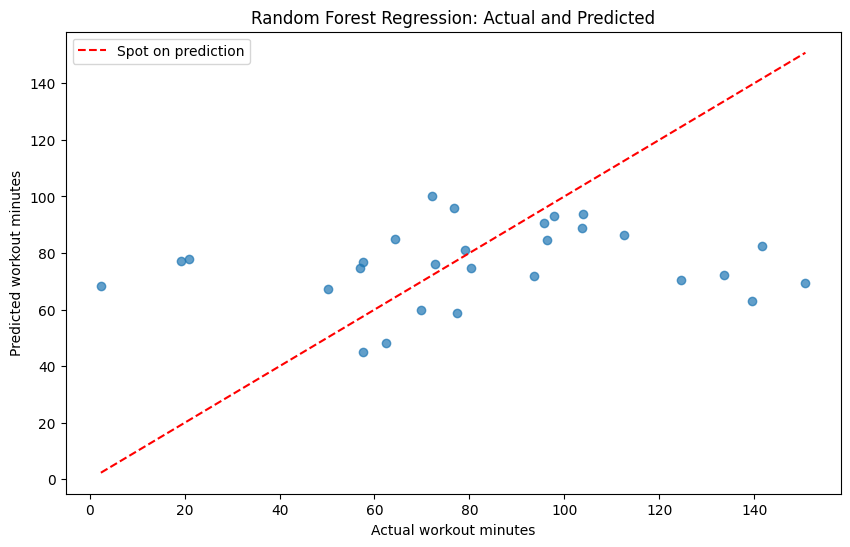

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_rf_reg, alpha=0.7)
min_val = min(y_test_reg.min(), y_pred_rf_reg.min())
max_val = max(y_test_reg.max(), y_pred_rf_reg.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--", label="Spot on prediction")
plt.xlabel("Actual workout minutes")
plt.ylabel("Predicted workout minutes")
plt.title("Random Forest Regression: Actual and Predicted")
plt.legend()

reg_path = FIG_DIR / "regression_results.png"
plt.savefig(reg_path, dpi=200, bbox_inches="tight")

plt.show()